<a href="https://colab.research.google.com/github/WuzI38/Data/blob/Jupyter/MidiGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second attempt on music generation

## Download data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download programgeek01/anime-music-midi

  0% 0.00/707k [00:00<?, ?B/s]
100% 707k/707k [00:00<00:00, 114MB/s]


In [5]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

In [6]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...


## Loading and preprocessing

### Parsing files

In [42]:
import os
from music21 import *
from fractions import Fraction

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

KeyboardInterrupt: ignored

In [8]:
midi_list[0]

<music21.stream.Score 0x7f1048476070>

### Extracting notes and chords



In [9]:
def fragmentise(midi_stream):
  return [part.flat.notes for part in midi_stream.parts]

In [10]:
def signature(midi_stream):
  sig = midi_stream.getTimeSignatures()[0]
  return [sig.numerator, sig.denominator]

In [11]:
frag = fragmentise(midi_list[2])
frag

[<music21.stream.iterator.StreamIterator for Part:0x7f1033a518b0_flat @:0>]

In [12]:
sg = signature(frag[0])
sg

[4, 4]

In [43]:
# Part one - extract notes from both streams and save them into a list
def get_all_notes(midi_piece):
  all_notes = list()
  note_types = set()
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      pitch = str(max(0.0, nt.pitch.ps))
      all_notes.append([nt.offset, pitch, nt.duration.quarterLength])
    elif isinstance(nt, chord.Chord):
      pitches = sorted([str(max(0.0, n.ps)) for n in nt.pitches])
      pitches = ' '.join(pitches)
      all_notes.append([nt.offset, pitches, nt.duration.quarterLength])
  return all_notes
  
notes_list = get_all_notes(midi_list[0])
notes_list[:10]

[[8.0, '68.0', 0.25],
 [8.25, '68.0', 0.0],
 [8.5, '69.0', 0.0],
 [8.75, '69.0', 0.0],
 [9.0, '70.0', 0.0],
 [9.25, '70.0', 0.0],
 [9.5, '71.0', 0.0],
 [9.75, '71.0', 0.0],
 [10.0, '72.0', 0.0],
 [10.25, '72.0', 0.0]]

In [14]:
# Part 2 extract all chord types from the dataset
import numpy as np

def get_chord_types(dataset):
  chord_types = dict()
  for d in dataset:
    notes_list = np.array(get_all_notes(d))
    strings = notes_list[:, 1]
    for s in strings:
      chord_types[s] = 1 + chord_types[s] if chord_types.get(s) is not None else 1
  return chord_types

types = get_chord_types(midi_list)

In [15]:
print(len(types))

1881


### Counting invidual chords and removing the rare ones

In [16]:
chord_counts = dict()
for item in sorted(list(types.values())):
  chord_counts[str(item)] = 1 + chord_counts[str(item)] if chord_counts.get(str(item)) is not None else 1

chord_counts = {k: v for k, v in chord_counts.items() if v > 1}

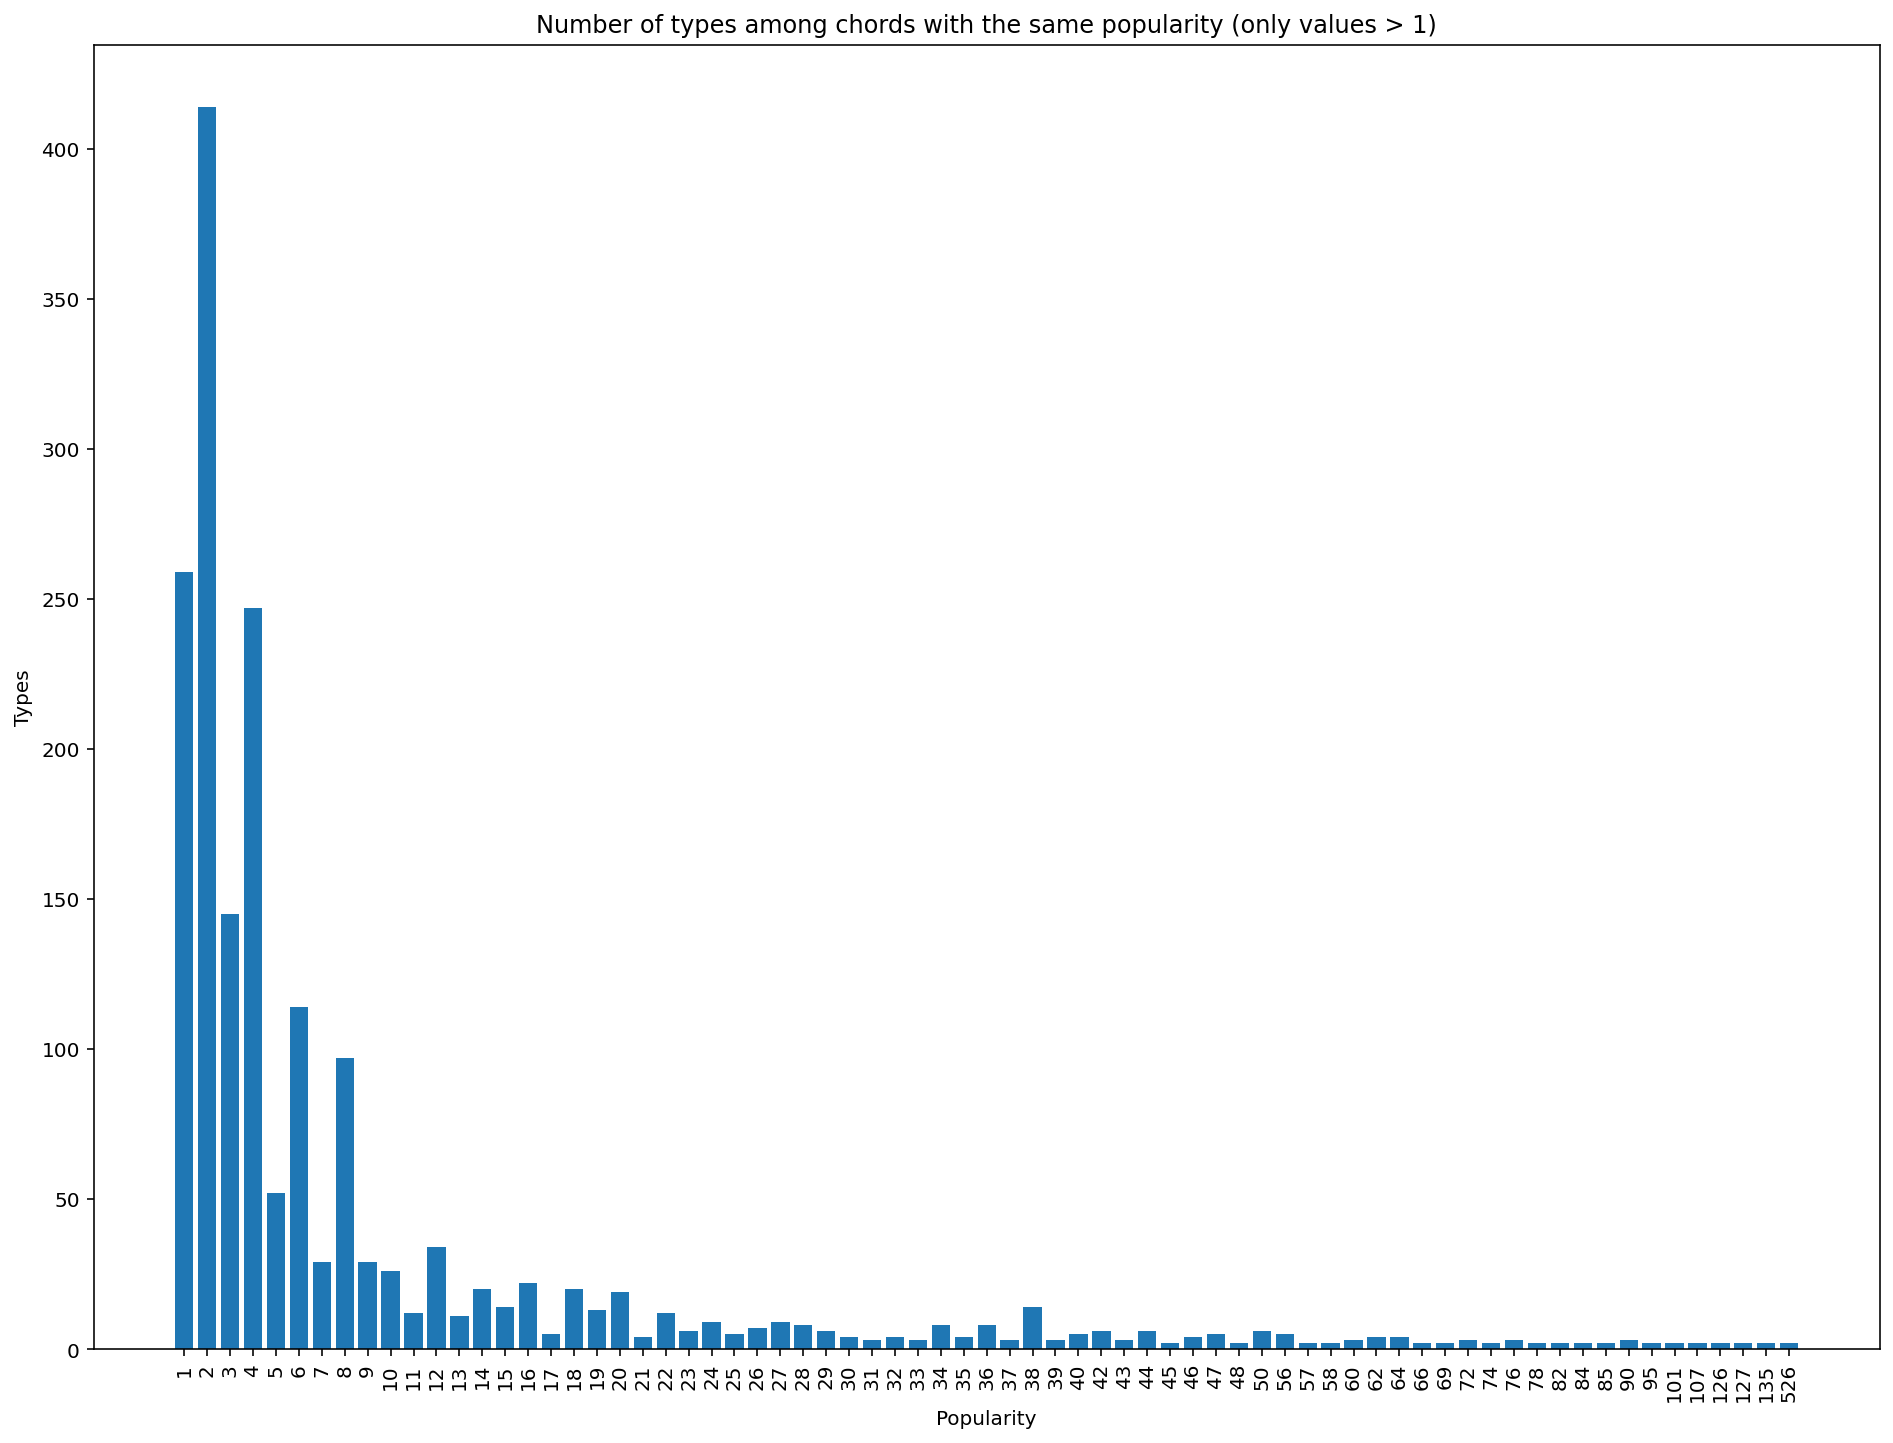

In [17]:
# Plotting the values
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary as lists
keys = list(chord_counts.keys())
values = list(chord_counts.values())

# Change size
plt.figure(figsize=(16, 12))

# Create a bar chart using the plot function
plt.bar(keys, values)

# Add a title and axis labels
plt.title('Number of types among chords with the same popularity (only values > 1)')
plt.xlabel('Popularity')
plt.ylabel('Types')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [18]:
from statistics import mean
HOW_MANY = 20
means = [mean([len(k)//4 for k, v in types.items() if v <= i]) for i in range(1, HOW_MANY + 1)]

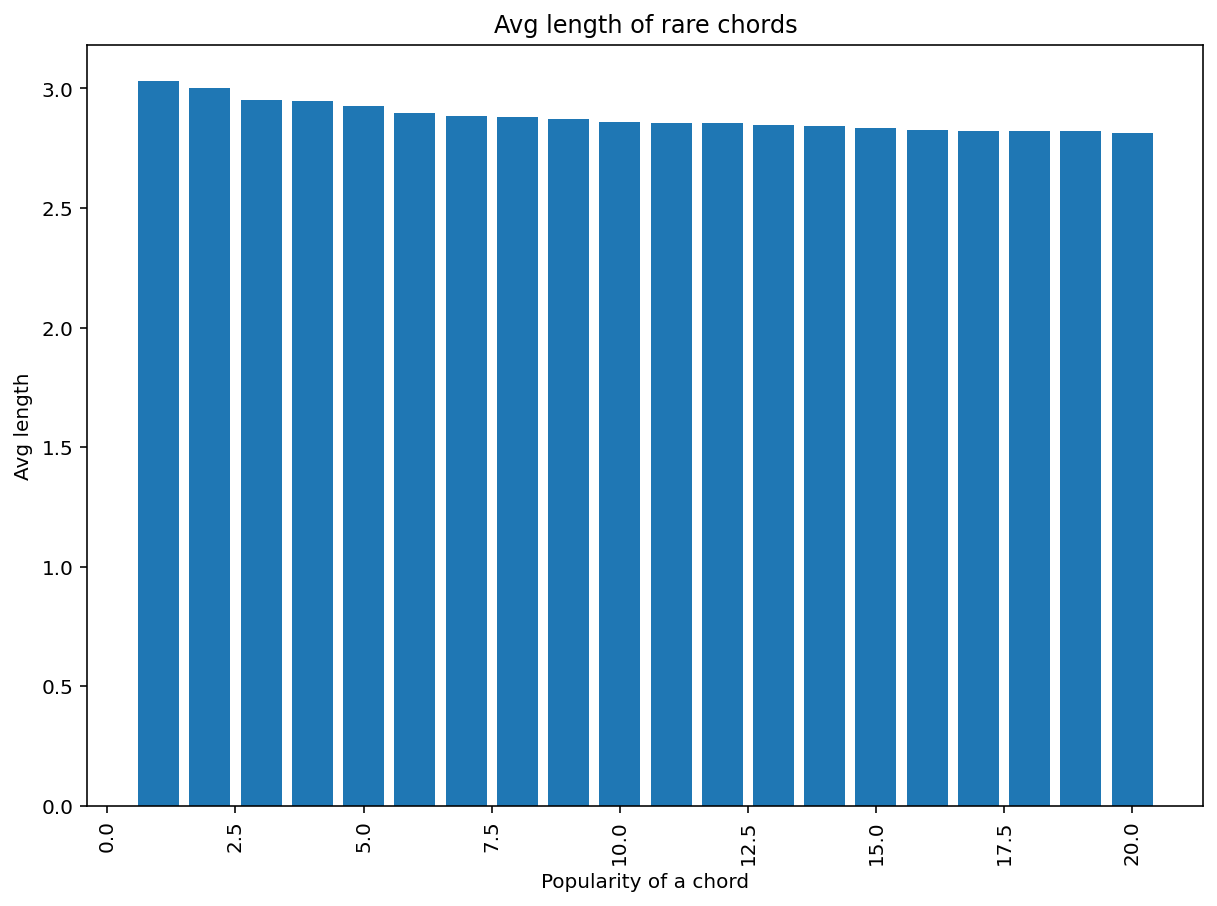

In [19]:
# Plotting the means
plt.figure(figsize=(10, 7))

# Create a bar chart using the plot function
plt.bar(list(range(1, HOW_MANY + 1)), means)

# Add a title and axis labels
plt.title('Avg length of rare chords')
plt.xlabel('Popularity of a chord')
plt.ylabel('Avg length')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

The avg length is around 3 for the rare chords, so I can probably shorten them to 2 notes for the encoding purposes, so i don't have to use 1881 different values

## Visualize melodies

In [37]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

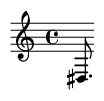

In [38]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(0.75)
show(n)

In [39]:
play(n)

In [60]:
def create_midi_part(part_n):
  melody = get_all_notes(part_n)
  melody_ready = []
  # Create really ugly and unnecessary for loop just for 
  for sound in melody:
    if len(sound[1]) > 4:
      new_note = note.Note(float(sound[1]), quarterLength = sound[2]) # use .nameWithOctave for note name only
    else:
      # new_note = chord.Chord([float (s) for s in sound[1].split()], quarterLength = sound[2]) <--- error here
      pass
    new_note.offset = sound[0]
    melody_ready.append(new_note)
  return melody_ready

In [61]:
melody_visual = create_midi_part(midi_list[0])
melody_midi = stream.Stream(melody_visual)

## Simpifying chords and encoding

In [34]:
LIMIT = 8

### Check if removing rare chords helps
types_short = dict()
id = 0
for key, value in types.items(): 
  kcp = key[:9] if value <= LIMIT and len(key) > 9 else key
  if types_short.get(kcp) is None:
    types_short[kcp] = id
    id += 1

print(len(types_short))

1176


### Encoding

{'68.0': 0,
 '69.0': 1,
 '70.0': 2,
 '71.0': 3,
 '72.0': 4,
 '73.0': 5,
 '74.0': 6,
 '75.0': 7,
 '84.0': 8,
 '85.0': 9,
 '87.0': 10,
 '80.0': 11,
 '82.0': 12,
 '67.0 72.0': 13,
 '68.0 75.0': 14,
 '75.0 80.0': 15,
 '80.0 84.0': 16,
 '82.0 85.0': 17,
 '82.0 89.0': 18,
 '84.0 87.0': 19,
 '79.0 82.0': 20,
 '85.0 89.0': 21,
 '80.0 87.0': 22,
 '75.0 85.0': 23,
 '72.0 84.0': 24,
 '84.0 92.0': 25,
 '92.0 99.0': 26,
 '87.0 97.0': 27,
 '84.0 96.0': 28,
 '97.0': 29,
 '91.0 99.0': 30,
 '94.0': 31,
 '91.0': 32,
 '89.0': 33,
 '78.0': 34,
 '64.0': 35,
 '83.0': 36,
 '66.0': 37,
 '90.0': 38,
 '52.0': 39,
 '59.0': 40,
 '54.0': 41,
 '56.0': 42,
 '63.0': 43,
 '75.0 78.0': 44,
 '40.0': 45,
 '76.0 85.0': 46,
 '73.0 83.0': 47,
 '47.0': 48,
 '70.0 78.0': 49,
 '78.0 82.0': 50,
 '80.0 83.0': 51,
 '42.0': 52,
 '73.0 78.0': 53,
 '78.0 83.0': 54,
 '58.0': 55,
 '44.0': 56,
 '51.0': 57,
 '61.0': 58,
 '78.0 85.0': 59,
 '54.0 59.0': 60,
 '48.0 53.0': 61,
 '41.0 70.0': 62,
 '41.0': 63,
 '72.0 75.0': 64,
 '46.0 51.0': 6

Possible lengths are fractions with a denominator of 12

Time signatures' denominators are always equal to 4 